In [6]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer,BatchNormalization
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap


In [ ]:
# Path to the weights file
weights_path = "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Define the InceptionV3 architecture (exclude top layers for feature extraction)
model = InceptionV3(weights=None, include_top=False, pooling='avg')
model.load_weights(weights_path)  # Load the weights into the model

# Path to Flickr8k images
image_dir = 'Images'

# Function to preprocess a single image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))  # Resize to 299x299
    img_array = img_to_array(img)                      # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)      # Add batch dimension
    img_array = preprocess_input(img_array)           # Normalize
    return img_array

# Process all images
def extract_features(image_dir, model):
    features = {}
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        img_array = preprocess_image(img_path)
        features[img_name] = model.predict(img_array)[0]  # Extract features
    return features

# Extract and save features
image_features = extract_features(image_dir, model)
np.save('image_features.npy', image_features)  # Save as a numpy array

In [ ]:
np.save('image_features.npy', image_features)  # Save as a numpy array


In [2]:
import re
from collections import defaultdict

# Load the captions file
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
    return captions

# Clean a single caption
def clean_caption(caption):
    caption = caption.lower()  # Convert to lowercase
    caption = re.sub(r"[^a-zA-Z0-9\s]", "", caption)  # Remove special characters
    caption = re.sub(r"\s+", " ", caption).strip()  # Remove extra spaces
    return caption

# Clean and tokenize all captions
def preprocess_captions(captions):
    captions_dict = defaultdict(list)
    for line in captions:
        line = line.strip()  # Remove leading/trailing whitespace
        
        if not line:  # Skip empty lines
            continue
        
        # Split based on the first comma
        parts = line.split(",", 1)  # Splits into two parts: image filename and caption text
        
        if len(parts) != 2:  # Skip lines that don't have exactly two parts
            continue
        
        image, caption = parts
        image = image.split("#")[0]  # Remove caption index (e.g., 0.jpg#0)
        cleaned_caption = clean_caption(caption)
        captions_dict[image].append(cleaned_caption)
    
    return captions_dict

# Example usage
captions_file = "captions.txt/captions.txt"
raw_captions = load_captions(captions_file)
processed_captions = preprocess_captions(raw_captions)

# Check the result for an example image
example_image = '1000268201_693b08cb0e.jpg'
print(f"Captions for {example_image}:")
for caption in processed_captions[example_image]:
    print(caption)


Captions for 1000268201_693b08cb0e.jpg:
a child in a pink dress is climbing up a set of stairs in an entry way
a girl going into a wooden building
a little girl climbing into a wooden playhouse
a little girl climbing the stairs to her playhouse
a little girl in a pink dress going into a wooden cabin


In [3]:
from collections import Counter

# Create a vocabulary with a frequency threshold
def build_vocabulary(captions_dict, threshold=5):
    word_counts = Counter()
    for captions in captions_dict.values():
        for caption in captions:
            word_counts.update(caption.split())
    
    # Include only words that meet the threshold
    vocab = [word for word, count in word_counts.items() if count >= threshold]
    vocab = sorted(vocab)  # Optional: sort vocabulary
    return vocab

# Build the vocabulary
vocab = build_vocabulary(processed_captions, threshold=5)
print(f"Vocabulary size: {len(vocab)}")


Vocabulary size: 2991


In [4]:
# Create mappings for the vocabulary (with padding and special tokens)
def create_mappings(vocab):
    word_to_index = {word: idx + 1 for idx, word in enumerate(vocab)}  # Reserve 0 for padding
    word_to_index["<start>"] = len(word_to_index) + 1  # Add <start> token
    word_to_index["<end>"] = len(word_to_index) + 1    # Add <end> token
    word_to_index["<unk>"] = len(word_to_index) + 1    # Add <unk> token for unknown words
    
    index_to_word = {idx: word for word, idx in word_to_index.items()}
    return word_to_index, index_to_word

# Convert captions to integer sequences
def captions_to_sequences(captions_dict, word_to_index):
    sequences = {}
    for image, captions in captions_dict.items():
        sequences[image] = []
        for caption in captions:
            seq = [word_to_index["<start>"]]  # Start token
            seq += [word_to_index.get(word, word_to_index["<unk>"]) for word in caption.split()]  # Handle OOV
            seq.append(word_to_index["<end>"])  # End token
            sequences[image].append(seq)
    return sequences

# Assuming `processed_captions` is your dictionary with image and corresponding captions
# `vocab` is the list of unique words in your captions

word_to_index, index_to_word = create_mappings(vocab)

# Convert captions to sequences
caption_sequences = captions_to_sequences(processed_captions, word_to_index)

# Example output for a sample image
print(caption_sequences['1000268201_693b08cb0e.jpg'])  # This will show the sequences for the image


[[2992, 8, 498, 1280, 8, 1877, 770, 1313, 532, 2823, 8, 2222, 1697, 2470, 1280, 56, 2994, 2904, 2993], [2992, 8, 1057, 1078, 1311, 8, 2959, 356, 2993], [2992, 8, 1481, 1057, 532, 1311, 8, 2959, 1908, 2993], [2992, 8, 1481, 1057, 532, 2659, 2470, 2701, 1200, 1908, 2993], [2992, 8, 1481, 1057, 1280, 8, 1877, 770, 1078, 1311, 8, 2959, 2994, 2993]]


In [7]:
data = pd.read_csv("captions.txt/captions.txt", header=None, names=['image', 'caption'])
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [8]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "<start> "+data['caption']+" <end>"
    return data

In [9]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[2, 18, 315, 63, 195, 116, 1]

In [11]:
# Image ID + \t + Caption
captions_IDs = []
for i in range(len(captions)):
    #  Adding 'start' word and 'end' word to the captions
    item = raw_captions[i].split(',')[0]+"\t"+captions[i]
    captions_IDs.append(item)
    
captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\t<start> child in pink dress is climbing up set of stairs in an entry way <end>',
  '1000268201_693b08cb0e.jpg\t<start> little girl climbing the stairs to her playhouse <end>',
  '1001773457_577c3a7d70.jpg\t<start> black dog and tri-colored dog playing with each other on the road <end>',
  '1001773457_577c3a7d70.jpg\t<start> two dogs on pavement moving toward each other <end>',
  '1002674143_1b742ab4b8.jpg\t<start> small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it <end>',
  '1003163366_44323f5815.jpg\t<start> man lays on bench while his dog sits by him <end>',
  '1003163366_44323f5815.jpg\t<start> shirtless man lies on park bench with his dog <end>'],
 40455)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load the extracted features
image_features = np.load('image_features.npy', allow_pickle=True).item()  # Ensure it's loaded as a dictionary

# Assuming captions_IDs is a list of strings like 'image_name\tcaption'
# Split into training, validation, and test sets
train_image_ids, val_image_ids = train_test_split(list(image_features.keys()), test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

# Function to split image features
def split_features(image_features, train_ids, val_ids, test_ids):
    train_features = {k: image_features[k] for k in train_ids}
    val_features = {k: image_features[k] for k in val_ids}
    test_features = {k: image_features[k] for k in test_ids}
    return train_features, val_features, test_features

# Split the image features
train_features, val_features, test_features = split_features(image_features, train_image_ids, val_image_ids, test_image_ids)

# Save the splits
np.save('train_image_features.npy', train_features)
np.save('val_image_features.npy', val_features)
np.save('test_image_features.npy', test_features)

# Optional: Verify the splits
print(f"Train: {len(train_features)}, Val: {len(val_features)}, Test: {len(test_features)}")


Train: 6877, Val: 1092, Test: 122


In [12]:
# Load the saved .npy files
train_image_features_np = np.load('train_image_features.npy', allow_pickle=True).item()
val_image_features_np = np.load('val_image_features.npy', allow_pickle=True).item()
test_image_features_np = np.load('test_image_features.npy', allow_pickle=True).item()

# Get the keys from each feature set
train_image_ids = set(train_image_features_np.keys())
val_image_ids = set(val_image_features_np.keys())
test_image_ids = set(test_image_features_np.keys())

train_image_features  = {}
val_image_features  = {}
test_image_features  = {}

# Use the loaded data to populate train, validation, and test dictionaries
train_image_features = {image_id: features.flatten() for image_id, features in train_image_features_np.items()}
val_image_features = {image_id: features.flatten() for image_id, features in val_image_features_np.items()}
test_image_features = {image_id: features.flatten() for image_id, features in test_image_features_np.items()}


# Ensure captions are correctly formatted and match the image IDs
train_captions, val_captions, test_captions = [], [], []

for caption in captions_IDs:
    image_id, _ = caption.split('\t', 1)  # Only split on the first tab

    # Check if the image_id exists in the feature dictionary
    if image_id in train_image_ids:
        train_captions.append(caption)
    elif image_id in val_image_ids:
        val_captions.append(caption)
    elif image_id in test_image_ids:
        test_captions.append(caption)
    else:
        print(f"Unknown image ID: {image_id}")  # This helps debug any missing image_ids

# Check for correct distribution of captions
print("Sample captions:")
print("Train:", train_captions[0] if train_captions else "No train captions")
print("Validation:", val_captions[0] if val_captions else "No validation captions")
print("Test:", test_captions[0] if test_captions else "No test captions")
print("Counts:", len(train_captions), len(val_captions), len(test_captions))


Sample captions:
Train: 1000268201_693b08cb0e.jpg	<start> child in pink dress is climbing up set of stairs in an entry way <end>
Validation: 1001773457_577c3a7d70.jpg	<start> black dog and spotted dog are fighting <end>
Test: 1042590306_95dea0916c.jpg	<start> man and woman pose for the camera while another man looks on <end>
Counts: 34385 5460 610


In [13]:
from tensorflow.keras.utils import to_categorical

def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size, vocab_size = 8483):
    num_samples = len(captions)
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        batch_captions = captions[start:end]
        
        # Preprocess captions to remove <start> and <end> if they exist
        batch_image_ids = []  # To store the image IDs
        batch_descriptions = []  # To store the caption descriptions

        for caption in batch_captions:
            image_id, description = caption.split('\t', 1)  # Split on the first tab
            batch_image_ids.append(image_id)
            batch_descriptions.append(description.strip())  # Remove leading/trailing spaces from caption
        
        try:
            # Get image features using the image ID (before \t)
            batch_image_features = [image_features[image_id] for image_id in batch_image_ids]
        except KeyError as e:
            print(f"KeyError: {e} - The caption does not match any key in image_features")
            continue

        input_image_features = []  # Shape: (batch_size, 2048)
        input_caption_tokens = []  # Shape: (batch_size, max_caption_length)
        next_word_tokens = []      # Shape: (batch_size,)

        # Process each caption and its corresponding image feature
        for description, image_feature in zip(batch_descriptions, batch_image_features):
            tokens = tokenizer.texts_to_sequences([description])[0]
            for i in range(1, len(tokens)):
                input_image_features.append(image_feature)
                input_caption_tokens.append(tokens[:i])
                next_word_tokens.append(tokens[i])

        # Pad sequences for input_caption_tokens to max_caption_length
        input_caption_tokens = tf.keras.preprocessing.sequence.pad_sequences(
            input_caption_tokens, maxlen=max_caption_length, padding='post'
        )

        # One-hot encode next_word_tokens
        next_word_tokens_one_hot = to_categorical(next_word_tokens, num_classes=vocab_size)

        # Yield the inputs and one-hot encoded next word tokens
        yield (np.array(input_image_features), np.array(input_caption_tokens)), next_word_tokens_one_hot
 
        
# Defining the maximum length of captions
max_caption_length = max(len(caption.split()) for caption in captions) + 1

# Defining the CNN output dimension (size of feature vector from InceptionV3)
cnn_output_dim = 2048 

# Defining batch size
batch_size_train = 270
batch_size_val = 150


In [28]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    # Encoder Model
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1) # Adding a Dense layer to the CNN output to match the decoder output size
    fe3 = BatchNormalization()(fe2)
    
    # Decoder Model
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)
    
    # Output
    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    # Returning The Model
    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model
    
# Building the model
caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()

Model: "Image_Captioning"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Features_Input      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ Features_Input[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Sequence_Input      │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    524,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 35, 256)   │  2,171,648 │ Sequence_Input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_7         │ (None, 35)        │          0 │ Sequence_Input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ embedding_1[0][0… │
│                     │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 8483)      │  2,180,131 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,476,643 (20.89 MB)

 Trainable params: 5,472,035 (20.87 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [29]:
# Defining early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.6).numpy())  # Convert Tensor to float

# Learning Rate Scheduler
lr_schedule = LearningRateScheduler(lr_scheduler)


In [30]:
output_signature = (
    (tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),  # Image features
     tf.TensorSpec(shape=(None,), dtype=tf.int32)),        # Input caption tokens
    tf.TensorSpec(shape=(None,), dtype=tf.float32)         # Next word tokens
)

gen = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size=32)

# Get one batch from the generator
sample = next(gen)

# Extract the inputs and outputs
inputs, next_word_tokens = sample

# Print the shapes of the inputs and outputs
input_image_features, input_caption_tokens = inputs
print(f"Shape of input_image_features: {input_image_features.shape}")
print(f"Shape of input_caption_tokens: {input_caption_tokens.shape}")
print(f"Shape of next_word_tokens: {next_word_tokens.shape}")



Shape of input_image_features: (353, 2048)
Shape of input_caption_tokens: (353, 35)
Shape of next_word_tokens: (353, 8483)


In [31]:
# Define the dataset creation function
def create_tf_dataset(generator, output_signature, steps_per_epoch):
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    ).take(steps_per_epoch)

# Define the generator functions for train and validation datasets
train_generator = lambda: data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_generator = lambda: data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

# Update output signature
output_signature = (
    (
        tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),  # Correctly shaped image features
        tf.TensorSpec(shape=(None, max_caption_length), dtype=tf.int32),  # Captions
    ),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32),  # Target outputs
)

train_dataset = create_tf_dataset(train_generator, output_signature, len(train_captions) // batch_size_train)
val_dataset = create_tf_dataset(val_generator, output_signature, len(val_captions) // batch_size_val)


# Use the datasets in your model training
history = caption_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[early_stopping, lr_schedule],
)


Epoch 1/15


c:\Users\Win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Features_Input', 'Sequence_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


    127/Unknown 280s 2s/step - loss: 5.6128

c:\Users\Win10\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


127/127 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - loss: 5.6071 - val_loss: 4.1898 - learning_rate: 0.0055
Epoch 2/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - loss: 3.7762 - val_loss: 3.7881 - learning_rate: 0.0030
Epoch 3/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - loss: 3.3235 - val_loss: 3.6681 - learning_rate: 0.0017
Epoch 4/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 343s 3s/step - loss: 3.0716 - val_loss: 3.6450 - learning_rate: 9.0718e-04
Epoch 5/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 337s 3s/step - loss: 2.9144 - val_loss: 3.6438 - learning_rate: 4.9787e-04
Epoch 6/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - loss: 2.8162 - val_loss: 3.6434 - learning_rate: 2.7324e-04
Epoch 7/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - loss: 2.7574 - val_loss: 3.6460 - learning_rate: 1.4996e-04
Epoch 8/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - loss: 2.7229 - val_loss: 3.6504 - learning_rate: 8.2297e-05
Epoch 9/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - loss: 2.7026 - val_loss: 3.6542 - learning_rate:

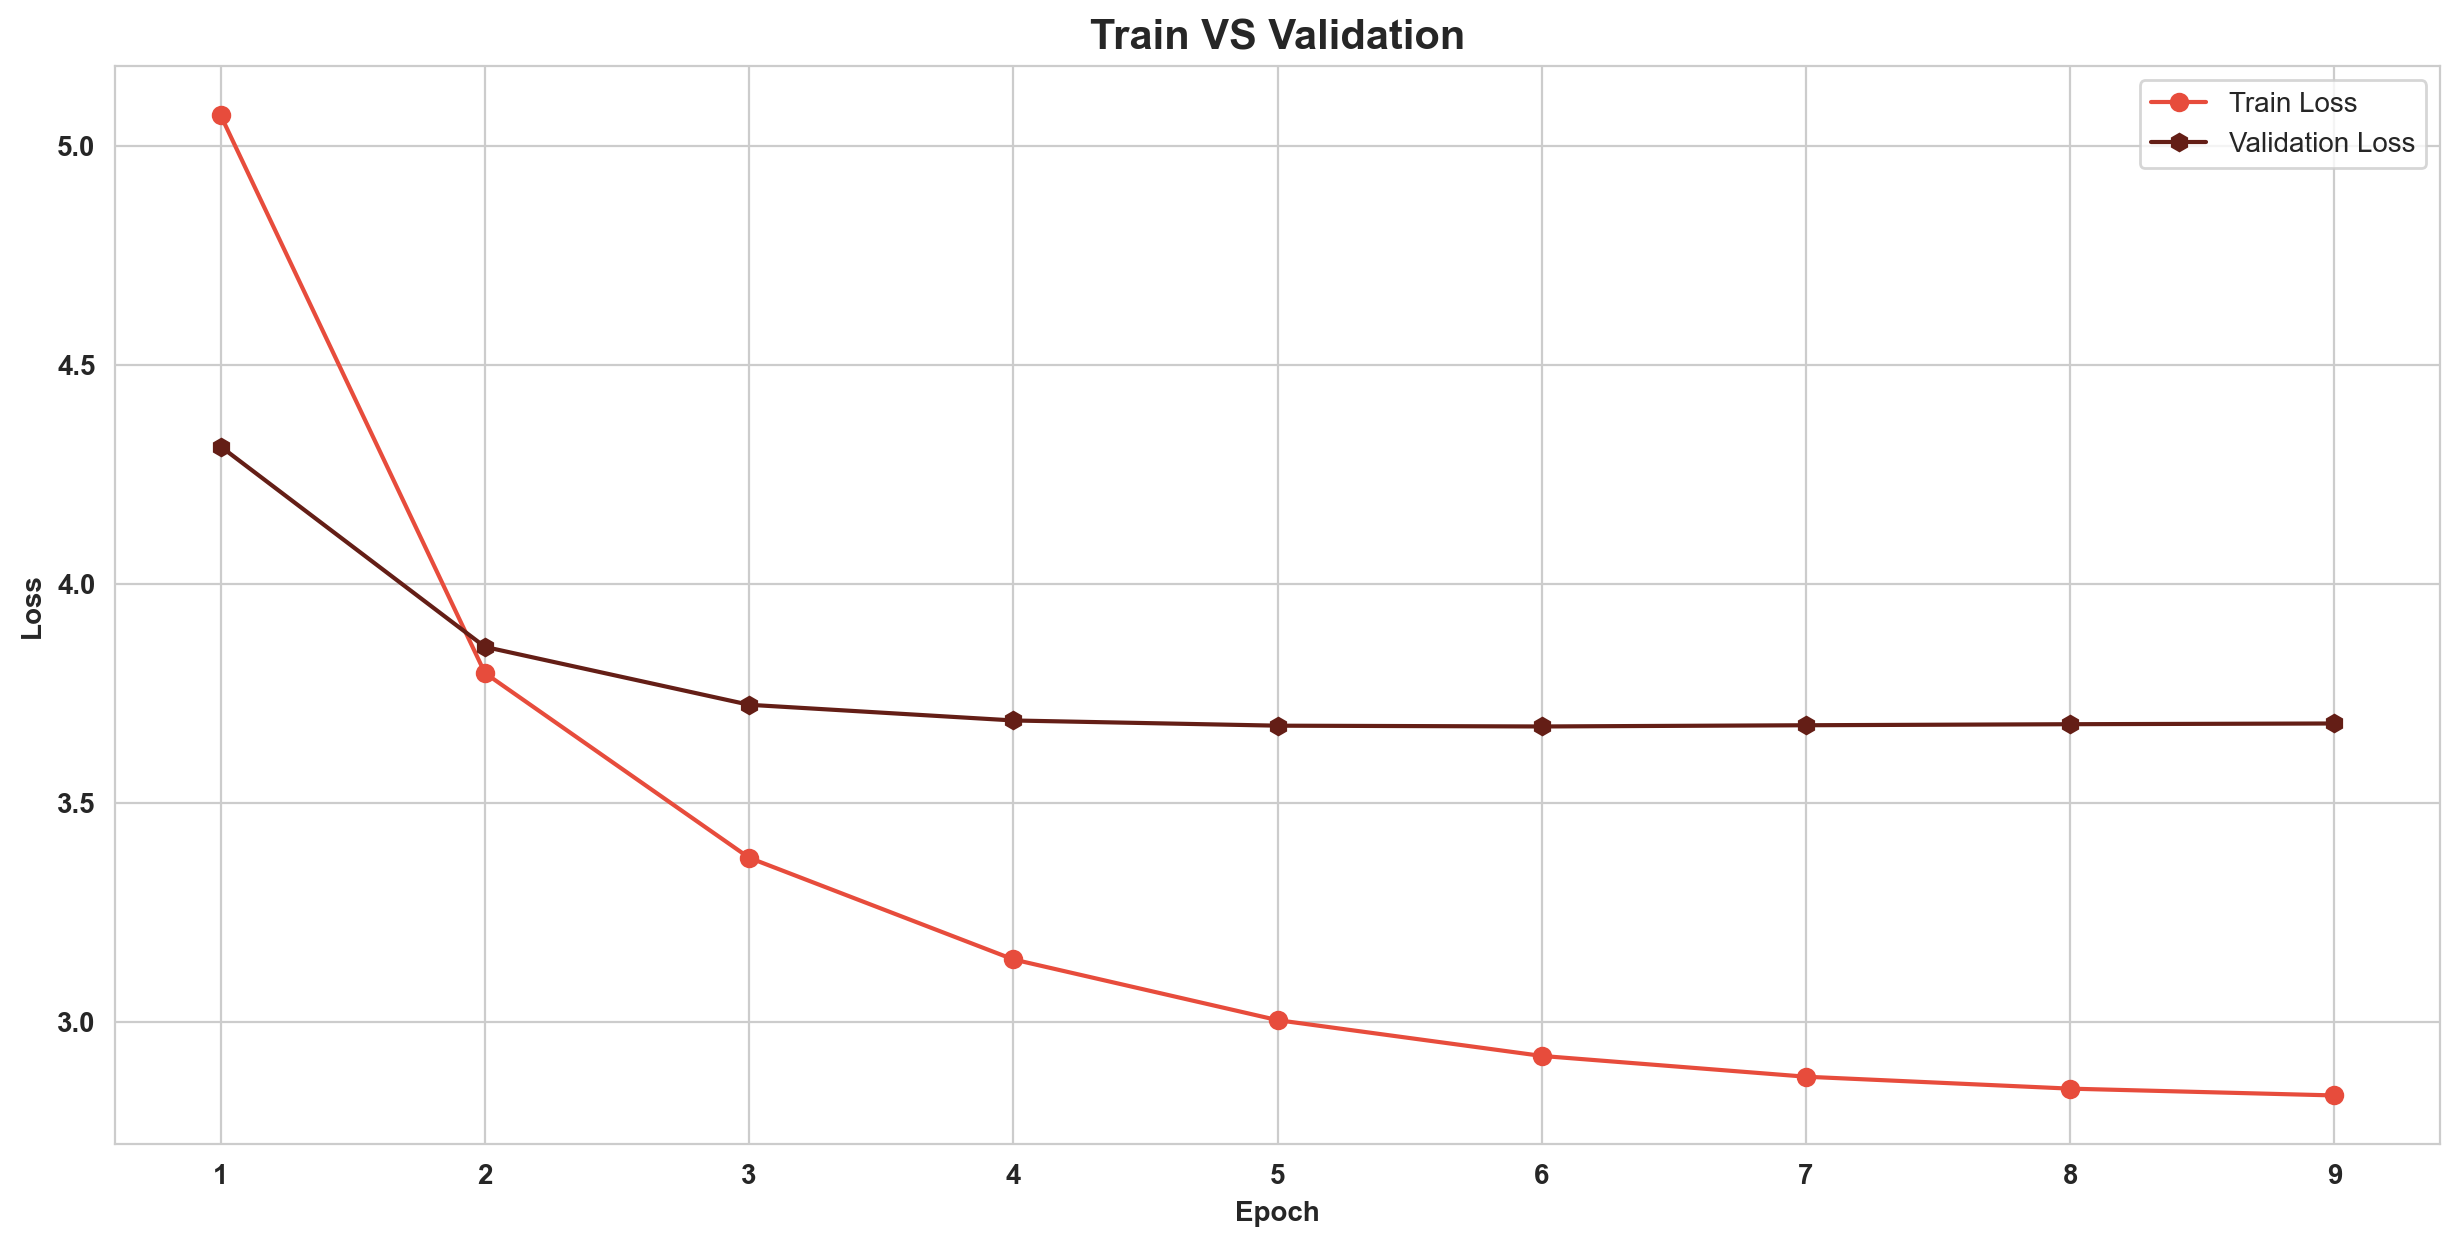

In [204]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [209]:
# A dictionary to access actual captions of each image by its ID
test_actual_captions = {}
for item in test_captions:
    image_id, caption = item.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)

In [210]:
def greedy_generator(image_features): # A function to generate captions
    # Each caption is started with the word 'start'
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1,max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        # Adding the predicted word to the sequence
        in_text += ' ' + word
        # When the model returns the word 'end' (which is the end word), the generating loop must be stopped 
        if word == 'end':
            break
            
    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')
    
    return in_text

In [211]:
def beam_search_generator(image_features, K_beams = 3, log = False):
    start = [tokenizer.word_index['start']]
    
    start_word = [[start, 0.0]]
    
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            # Sequence of most probable words based on the previous steps
            sequence  = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1,max_caption_length))
            
            preds = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
            
            # Sorting predictions by the probability and taking the last K_beams items.
            word_preds = np.argsort(preds[0])[-K_beams:]
            
            # Getting the top <K_beams>(n) predictions and creating a 
            #                              new list so as to put them via the model again.
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
                
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [tokenizer.index_word[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != 'end':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [216]:
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import corpus_bleu

# Calculate BLEU scores with proper tokenization
def BLEU_score(actual, greedy, beam_search):
    # Tokenize all captions
    actual_tokenized = [[word_tokenize(cap) for cap in refs] for refs in actual]
    greedy_tokenized = [word_tokenize(cap) for cap in greedy]
    beam_tokenized = [word_tokenize(cap) for cap in beam_search]

    # BLEU-1 and BLEU-2 for greedy captions
    score_greedy_1 = corpus_bleu(actual_tokenized, greedy_tokenized, weights=(1.0, 0.0, 0.0, 0.0))  # BLEU-1
    score_greedy_2 = corpus_bleu(actual_tokenized, greedy_tokenized, weights=(0.5, 0.5, 0.0, 0.0))  # BLEU-2

    # BLEU-1 and BLEU-2 for beam search captions
    score_BS_1 = corpus_bleu(actual_tokenized, beam_tokenized, weights=(1.0, 0.0, 0.0, 0.0))  # BLEU-1
    score_BS_2 = corpus_bleu(actual_tokenized, beam_tokenized, weights=(0.5, 0.5, 0.0, 0.0))  # BLEU-2

    # Prepare scores for display
    return [
        f'BLEU-2 Greedy: {round(score_greedy_2, 5)}',
        f'BLEU-1 Greedy: {round(score_greedy_1, 5)}',
        f'Greedy: {greedy[0]}',
        f'BLEU-2 Beam Search: {round(score_BS_2, 5)}',
        f'BLEU-1 Beam Search: {round(score_BS_1, 5)}',
        f'Beam Search: {beam_search[0]}'
    ]


In [213]:
from tqdm import tqdm  # Import tqdm for progress bar in VSCode

generated_captions = {}

# Use tqdm for progress bar
pbar = tqdm(total=len(test_image_features), desc="Generating Captions", position=0, leave=True, colour='green')
for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap
    pbar.update(1)  # Increment progress bar

pbar.close()  # Close the progress bar after loop completion


Generating Captions: 100%|██████████| 122/122 [01:06<00:00,  1.83it/s]



Debugging Captions:
Image ID: 3401437960_7da856e004.jpg
Actual Captions: ['<start> brown dog digging hole <end>', '<start> brown dog digging hole in front of plant <end>', '<start> brown dog is digging hole in the dirt <end>', '<start> dog digs hole in yard <end>', '<start> this brown dog is digging hole while there is plant nearby <end>']
Greedy Caption: brown dog is laying on the sidewalk
Beam Search Caption: brown dog is laying on the sidewalk

Debugging Captions:
Image ID: 2308271254_27fb466eb4.jpg
Actual Captions: ['<start> grey dog chasing brown dog in shallow water <end>', '<start> small black dog chasing small fluffy brown dog just above water <end>', '<start> two dogs moving through water close to the shore <end>', '<start> two dogs playing in lake <end>', '<start> two dogs playing on the shore <end>']
Greedy Caption: dog is running through the water
Beam Search Caption: two dogs playing in the water

Debugging Captions:
Image ID: 2354792215_eef2bdc753.jpg
Actual Captions: ['

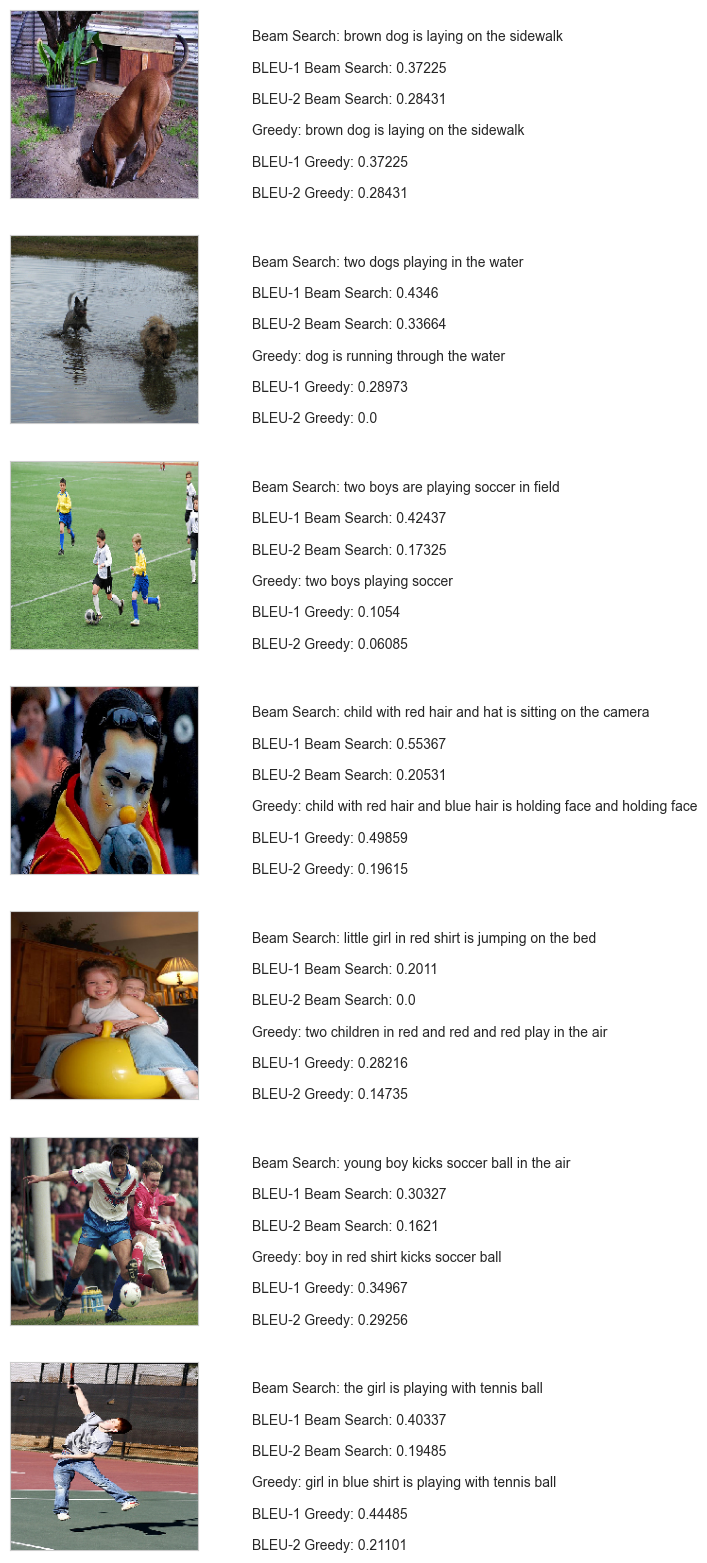

In [222]:
def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images, images_directory='Images/'):
    keys = list(data.keys())  # List of all test images
    images = [np.random.choice(keys) for _ in range(num_of_images)]  # Randomly select images
    
    count = 1
    fig = plt.figure(figsize=(6, 20))
    
    for filename in images:
        # Actual captions: Cleaned and tokenized
        actual_caps = data[filename]
        actual_caps_cleaned = [
            cap.replace("start ", "").replace(" end", "").strip()
            for cap in actual_caps
        ]
        
        # Generating captions
        greedy_cap = greedy_caps[filename].replace("start ", "").replace(" end", "").strip()
        beam_cap = beamS_generator(test_image_features[filename]).replace("start ", "").replace(" end", "").strip()
        
        # Debugging input structure
        print("\nDebugging Captions:")
        print(f"Image ID: {filename}")
        print(f"Actual Captions: {actual_caps_cleaned}")
        print(f"Greedy Caption: {greedy_cap}")
        print(f"Beam Search Caption: {beam_cap}")
        
        # Getting the BLEU scores
        try:
            caps_with_score = evaluator(
                [actual_caps_cleaned],  # Reference captions
                [greedy_cap],           # Predicted (Greedy) caption
                [beam_cap]              # Predicted (Beam Search) caption
            )
        except Exception as e:
            print(f"Error computing BLEU score for {filename}: {e}")
            continue
        
        # Load and display the image
        image_load = load_img(images_directory + filename, target_size=(199, 199, 3))
        ax = fig.add_subplot(num_of_images, 2, count, xticks=[], yticks=[])
        ax.imshow(image_load)
        count += 1

        # Display BLEU scores and captions
        ax = fig.add_subplot(num_of_images, 2, count)
        plt.axis('off')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0, i, text, fontsize=10)
        count += 1
    
    plt.show()


visualization(test_actual_captions, generated_captions, beam_search_generator, BLEU_score, 7)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import cv2
import numpy as np

# Load the pre-trained InceptionV3 model for feature extraction
weights_path = "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = InceptionV3(weights=None, include_top=False, pooling='avg')
base_model.load_weights(weights_path)  # Load the weights into the model

# Function to preprocess a single frame from the live camera feed
def preprocess_frame(frame, target_size=(299, 299)):
    # Resize the frame to the required input size
    frame_resized = cv2.resize(frame, target_size)
    frame_array = img_to_array(frame_resized)  # Convert to numpy array
    frame_array = np.expand_dims(frame_array, axis=0)  # Add batch dimension
    return preprocess_input(frame_array)  # Normalize the input

# Extract image features using the pre-trained InceptionV3 model
def extract_features(preprocessed_frame, model):
    return model.predict(preprocessed_frame)

# Beam search generator function
def beam_search_generator(image_features, caption_model, tokenizer, max_caption_length, K_beams=3, log=False):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]
    
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            sequence = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1, max_caption_length))
            preds = caption_model.predict([image_features.reshape(1, -1), sequence], verbose=0)
            
            word_preds = np.argsort(preds[0])[-K_beams:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w])  # Assign log probability
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        
        start_word = sorted(temp, reverse=False, key=lambda l: l[1])[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [tokenizer.index_word[i] for i in start_word]

    final_caption = []
    for i in captions_:
        if i != 'end':
            final_caption.append(i)
        else:
            break
    
    return ' '.join(final_caption[1:])

# Live caption generator function
def live_caption_generator(caption_model, feature_extractor_model, tokenizer, max_caption_length):
    # Capture an image from the camera
    cap = cv2.VideoCapture(0)
    print("Press 'Space' to capture an image, or 'Q' to quit.")

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture image.")
            break

        # Display the webcam feed
        cv2.imshow("Live Camera", frame)

        # Wait for key press
        key = cv2.waitKey(1) & 0xFF
        if key == ord(' '):  # Space key to capture
            # Preprocess the captured frame
            preprocessed_frame = preprocess_frame(frame)

            # Extract features from the preprocessed frame
            image_features = extract_features(preprocessed_frame, feature_extractor_model)

            # Generate caption using the beam search generator
            caption = beam_search_generator(image_features, caption_model, tokenizer, max_caption_length, K_beams=3)
            print(f"Generated Caption: {caption}")

            # Display the frame with the generated caption
            cv2.putText(frame, caption, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imshow("Generated Caption", frame)
            cv2.waitKey(0)  # Wait for user to close the window
            break

        elif key == ord('q'):  # Quit the application
            print("Exiting.")
            break

    cap.release()
    cv2.destroyAllWindows()

# Example usage:
live_caption_generator(caption_model, base_model, tokenizer, max_caption_length)


Press 'Space' to capture an image, or 'Q' to quit.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Generated Caption: young girl in the middle girl in the room


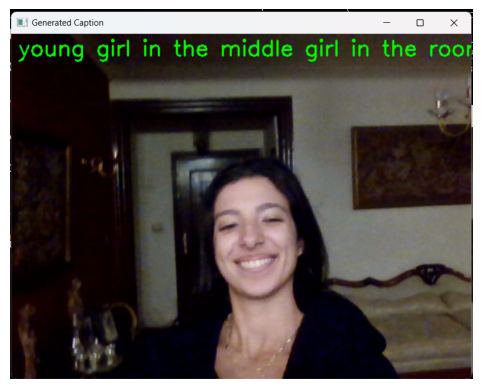

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display an image
img = mpimg.imread('Screenshot 2024-12-02 042214.png')  
plt.imshow(img)
plt.axis('off')  
plt.show()
